<a href="https://colab.research.google.com/github/MDfarazuddin99/Masked_Face_Recognition/blob/master/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First of all, You will need to install a face detector library. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.7MB/s 


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os
from google.colab.patches import cv2_imshow
import dlib


Using TensorFlow backend.


# **Take Test picture**

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename, quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
from IPython.display import Image
import os

try:
    file_name = 'test_1.jpg'
    filename = take_photo(file_name)
    print('Saved to {}'.format(filename))
    
# Show the image which was just taken.
    # display(Image(filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

<IPython.core.display.Javascript object>

Saved to test_1.jpg


In [0]:
from PIL import Image
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    img = Image.open(filename)
    # convert to RGB, if needed
    img = img.convert('RGB')
    # convert to array
    pixels = np.asarray(img)
    #create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    print(results[0]['box'])
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:int(0.75*y2), x1:x2]
    # resize pixels to the model size
    img = Image.fromarray(face)
    img = img.resize(required_size)
    face_array = np.asarray(img)
    plt.imshow(face_array)
    plt.show()
    return face_array

[263, 136, 195, 232]


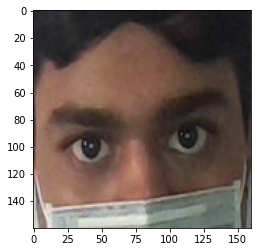

In [0]:
filename= "test_1.jpg"
a = extract_face(filename)
plt.imsave('cropped_test_1.jpg',a)

# **Align Face**

In [0]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

2
(112, 92) (39, 99) (75, 95) 5.477368728828878


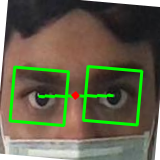

In [0]:
img = cv2.imread('cropped_test_1.jpg')
while 2:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray)
    print(len(eyes))
    if(len(eyes) > 2 ):
        (ex1,ey1,ew1,eh1) =  eyes[1]
        (ex2,ey2,ew2,eh2) = eyes[2]
        cv2.rectangle(img,(ex1,ey1),(ex1+ew1,ey1+eh1),(0,255,0),2)
        cv2.rectangle(img,(ex2,ey2),(ex2+ew2,ey2+eh2),(0,255,0),2)
        X1,Y1 = ex1+ew1//2,ey1+eh1//2
        X2,Y2 = ex2+ew2//2,ey2+eh2//2
        cv2.line(img, (X1,Y1), (X2,Y2),(0, 255, 0) ,2)
        angle = np.degrees(np.arctan2(abs(Y1 - Y2),abs(X1 - X2)))
        center = ((X1 + X2)//2 ,(Y1 + Y2)//2)
        cv2.circle(img, center, 2, (0,0,255), 3)
        print((ex1+ew1//2,ey1+eh1//2),(ex2+ew2//2,ey2+eh2//2),center,angle) 
        if angle < 30:
            rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
            img = cv2.warpAffine(img,rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR, borderValue=(255,255,255))

        cv2_imshow(img)
        # k = cv2.waitKey(30) & 0xff
    elif len(eyes) == 2:
        (ex1,ey1,ew1,eh1) =  eyes[0]
        (ex2,ey2,ew2,eh2) = eyes[1]
        cv2.rectangle(img,(ex1,ey1),(ex1+ew1,ey1+eh1),(0,255,0),2)
        cv2.rectangle(img,(ex2,ey2),(ex2+ew2,ey2+eh2),(0,255,0),2)
        X1,Y1 = ex1+ew1//2,ey1+eh1//2
        X2,Y2 = ex2+ew2//2,ey2+eh2//2
        cv2.line(img, (X1,Y1), (X2,Y2),(0, 255, 0) ,2)
        angle = np.degrees(np.arctan2(abs(Y1 - Y2),abs(X1 - X2)))
        center = ((X1 + X2)//2 ,(Y1 + Y2)//2)
        cv2.circle(img, center, 2, (0,0,255), 3)
        print((ex1+ew1//2,ey1+eh1//2),(ex2+ew2//2,ey2+eh2//2),center,angle) 
        if angle < 30:
            rot_mat = cv2.getRotationMatrix2D(center, -5, 1.0)
            img = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR, borderValue=(255,255,255))
        cv2_imshow(img)
        # k = cv2.waitKey(30) & 0xff

    break